# Промежуточная аттестация 3

## Импорт модулей

In [1]:
from ucimlrepo import fetch_ucirepo

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
    r2_score
)

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import h2o
from h2o.automl import H2OAutoML

## Константы

In [2]:
TARGET = "Age"
RANDOM_STATE = 777
TEST_SIZE = 0.2

# Задача1. Загрузка данных

Для выполнения задания выбран набор данных, целью которого является прогнозирование возраста моллюска по физическим измерениям. Возраст моллюска определяется путем разрезания раковины по конусу, окрашивания ее и подсчета количества колец с помощью микроскопа — скучная и трудоемкая задача. Для ее решения может помочь использование моделей машинного обучения.

In [3]:
abalone = fetch_ucirepo(id=1) 
  
X = abalone.data.features 
y = abalone.data.targets

# Преобразуем целевую переменную, чтобы она содержала возраст, а не количество колец
y.loc[:, ["Age"]] = y["Rings"].values + 1.5
y = y.drop(columns=["Rings"])

df = pd.concat([X, y], axis=1)
df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Age             4177 non-null   float64
dtypes: float64(8), object(1)
memory usage: 293.8+ KB


# Задача 2. Подготовка данных к проведению машинного обучения 

## Исследовательский анализ данных

In [5]:
# Выделим числовые и категориальные признаки
numeric_columns = [
    col for col in df.columns if df[col].dtype == "float64" if col != TARGET
]
categoric_columns = [col for col in df.columns if df[col].dtype == "object"]

In [6]:
def numeric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Минимум"] = df.min().round(2)
    stats["Максимум"] = df.max().round(2)
    stats["Среднее"] = df.mean().round(2)
    stats["Медиана"] = df.median().round(2)
    stats["Дисперсия"] = df.var().round(2)
    stats["Квантиль 0.1"] = df.quantile(0.1).round(2)
    stats["Квантиль 0.9"] = df.quantile(0.9).round(2)
    stats["Квартиль 1"] = df.quantile(0.25).round(2)
    stats["Квартиль 3"] = df.quantile(0.75).round(2)

    return stats


def categoric_columns_stats(df):
    stats = pd.DataFrame(index=df.columns)
    stats["Доля пропусков"] = df.isnull().mean()
    stats["Количество уникальных значений"] = df.nunique()
    stats["Мода"] = df.mode().transpose()

    return stats

In [7]:
# Результаты EDA для числовых признаков
numeric_columns_stats(df[numeric_columns + [TARGET]])

,Доля пропусков,Минимум,Максимум,Среднее,Медиана,Дисперсия,Квантиль 0.1,Квантиль 0.9,Квартиль 1,Квартиль 3
Length,0.0,0.08,0.82,0.52,0.55,0.01,0.36,0.66,0.45,0.62
Diameter,0.0,0.06,0.65,0.41,0.42,0.01,0.26,0.52,0.35,0.48
Height,0.0,0.00,1.13,0.14,0.14,0.00,0.09,0.18,0.12,0.16
Whole_weight,0.0,0.00,2.83,0.83,0.80,0.24,0.20,1.48,0.44,1.15
Shucked_weight,0.0,0.00,1.49,0.36,0.34,0.05,0.09,0.65,0.19,0.50
Viscera_weight,0.0,0.00,0.76,0.18,0.17,0.01,0.04,0.33,0.09,0.25
Shell_weight,0.0,0.00,1.00,0.24,0.23,0.02,0.06,0.42,0.13,0.33
Age,0.0,2.50,30.50,11.43,10.50,10.40,7.50,15.50,9.50,12.50


In [8]:
# Результаты EDA для категориальных признаков
categoric_columns_stats(df[categoric_columns])

,Доля пропусков,Количество уникальных значений,Мода
Sex,0.0,3,M


Данные не содержат пропущенные значения и имеют различный масштаб.

## Подготовка датасета к построению моделей ML

### Распределение целевой переменной

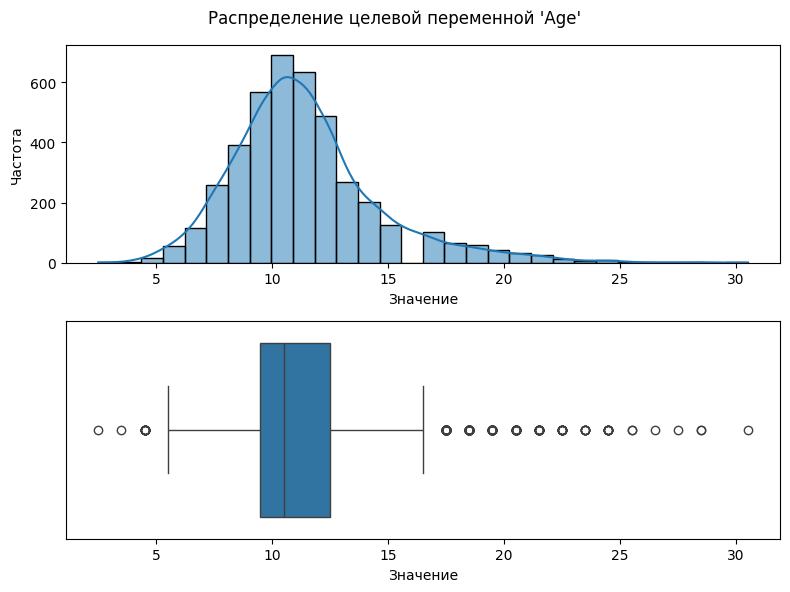

In [9]:
# Визуализация распределения целевой переменной
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df[TARGET], bins=30, kde=True, ax=ax[0])
ax[0].set_xlabel("Значение")
ax[0].set_ylabel("Частота")

sns.boxplot(df[TARGET], orient="h", ax=ax[1])
ax[1].set_xlabel("Значение")
ax[1].set_yticks([])

plt.suptitle(f"Распределение целевой переменной '{TARGET}'")
plt.tight_layout()
plt.show()

Распределение целевого признака похоже на нормальное распределение, немного скоженное вправо, что говорит о существовании моллюсков долгожителей.

### Обработка выбросов

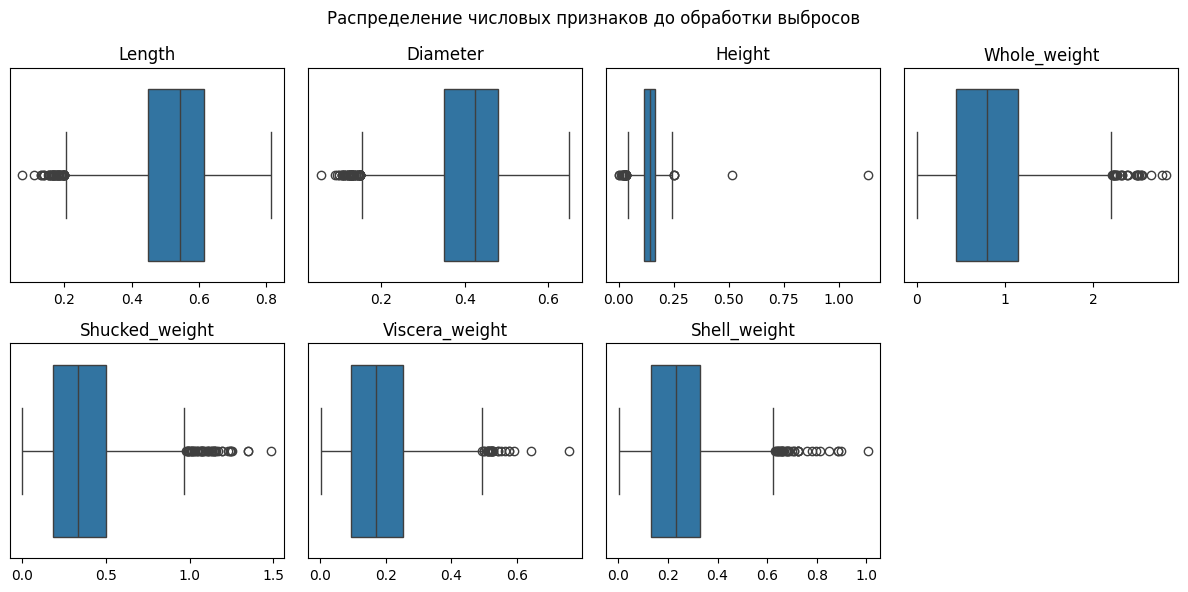

In [10]:
# Отображение распределения числовых признаков до обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(numeric_columns), len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков до обработки выбросов")
plt.tight_layout()
plt.show()

Признаки содержат заметную долю выбросов, обработаем их методом межквартильного интервала.

In [11]:
# Функция для обработки выбросов
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df


df = remove_outliers(df, numeric_columns)

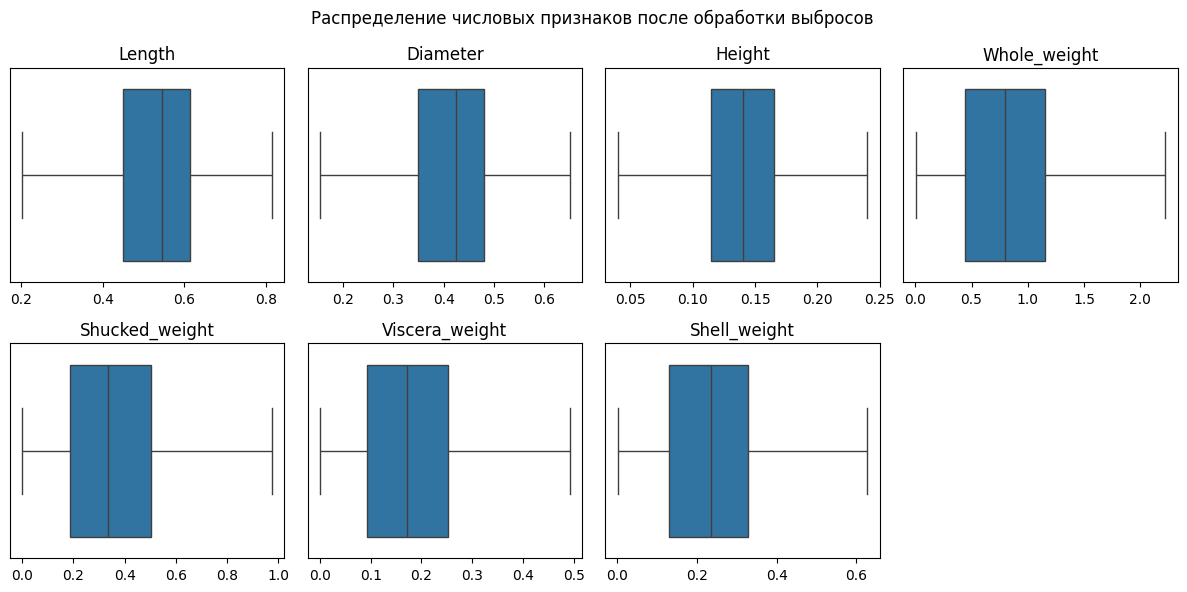

In [12]:
# Отображение распределения числовых признаков после обработки выбросов
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

for i, col in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, 4)
    sns.boxplot(df[numeric_columns][col], ax=ax[row_idx, col_idx], orient="h")
    ax[row_idx, col_idx].set_title(col)
    ax[row_idx, col_idx].set_xlabel(None)
    ax[row_idx, col_idx].set_yticks([])

for i in range(len(numeric_columns), len(ax.flatten())):
    fig.delaxes(ax.flatten()[i])

plt.suptitle("Распределение числовых признаков после обработки выбросов")
plt.tight_layout()
plt.show()

### Кодирование категориальных переменных

In [13]:
# Кодируем методом OneHotEncoding
df = pd.get_dummies(df, columns=categoric_columns, drop_first=True, dtype=int)

df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,1,0


### Анализ корреляций

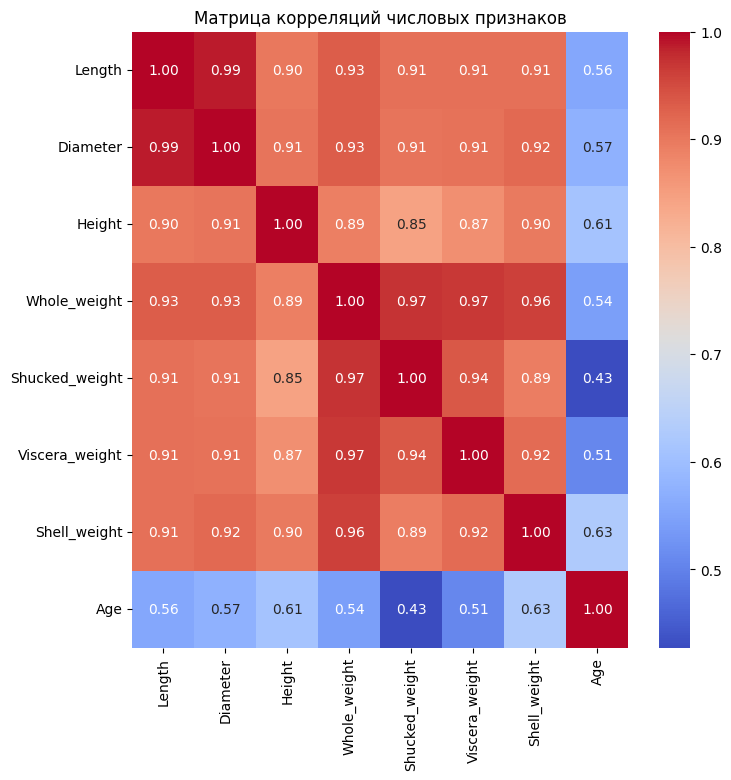

In [14]:
# Матрица корреляций
plt.figure(figsize=(8, 8))
correlation_matrix = df[numeric_columns + [TARGET]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций числовых признаков")
plt.show()

Можно видеть, что все числовые признаки имеют высокие коэффициенты линейной скоррелированности, удалить скоррелированные признаки не получится. Оставим их без изменения.

### Сохранение данных

In [15]:
df.to_csv("./data.csv", index=False)

Для решения задачи регрессии будем использовать следующие модели: линейная регрессия, регрессия knn, SVR, Random forest regressor, Регрессор Градиентного бустинга.

# Задача 3. Построение моделей машинного обучения

### Разделение данных

In [16]:
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# Нормализация данных
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_test_scaled[numeric_columns] = scaler.transform(X_test[numeric_columns])

X_train_scaled = X_train_scaled.values
X_test_scaled = X_test_scaled.values

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(f"X_train.shape={X_train.shape}, y_train.shape={y_train.shape}")
print(f"X_test.shape={X_test.shape}, y_test.shape={y_test.shape}\n")

print(f"X_train_scaled.shape={X_train_scaled.shape}")
print(f"X_test_scaled.shape={X_test_scaled.shape}")

X_train.shape=(3341, 9), y_train.shape=(3341,)
X_test.shape=(836, 9), y_test.shape=(836,)

X_train_scaled.shape=(3341, 9)
X_test_scaled.shape=(836, 9)


## Обучение моделей

### Линейная регрессия

In [17]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

### Регрессия knn

In [18]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    knr_params = {
        "n_neighbors": [3, 5, 7, 9, 11, 13, 15, 17, 19],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
        "leaf_size": [10, 20, 30, 40, 50, 60, 70, 80],
        "p": [1, 2],
    }

    knr_model = KNeighborsRegressor()
    knr_search = RandomizedSearchCV(
        knr_model,
        knr_params,
        n_iter=300,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
    )
    knr_search.fit(X_train_scaled, y_train)

    print("Найденные гиперпараметры:", knr_search.best_params_)

Найденные гиперпараметры: {'weights': 'distance', 'p': 1, 'n_neighbors': 15, 'leaf_size': 30, 'algorithm': 'brute'}

In [19]:
# Модель после подбора гиперпараметров
knr_params = {
    "weights": "distance",
    "p": 1,
    "n_neighbors": 15,
    "leaf_size": 30,
    "algorithm": "brute",
}

knr_model = KNeighborsRegressor()
knr_model.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred_knr = knr_model.predict(X_test_scaled)

### SVR

In [20]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    svr_params = {
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto", 0.01, 0.1, 1],
        "degree": [2, 3, 4],
    }

    svr_model = SVR()
    svr_search = RandomizedSearchCV(
        svr_model,
        svr_params,
        n_iter=100,
        cv=5,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
    svr_search.fit(X_train_scaled, y_train)

    print("Найденные гиперпараметры:", svr_search.best_params_)

Найденные гиперпараметры: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 3, 'C': 10}

In [21]:
# Модель после подбора гиперпараметров
svr_params = {"kernel": "rbf", "gamma": "auto", "degree": 3, "C": 10}

svr_model = SVR(**svr_params)
svr_model.fit(X_train_scaled, y_train)

# Предсказания на тестовых данных
y_pred_svr = svr_model.predict(X_test_scaled)

### Random forest regressor

In [22]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    rfr_params = {
        "n_estimators": [50, 100, 200, 300, 500],
        "max_depth": [None, 5, 10, 20, 30, 40, 50, 100],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "max_features": ["auto", "sqrt", "log2", None],
    }

    rfr_model = RandomForestRegressor(random_state=RANDOM_STATE)
    rfr_search = RandomizedSearchCV(
        rfr_model,
        rfr_params,
        n_iter=300,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
    )
    rfr_search.fit(X_train, y_train)

    print("Найденные гиперпараметры:", rfr_search.best_params_)

Найденные гиперпараметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': None}

In [23]:
# Модель после подбора гиперпараметров
rfr_params = {
    "n_estimators": 100,
    "min_samples_split": 10,
    "min_samples_leaf": 5,
    "max_features": "sqrt",
    "max_depth": None,
}

rfr_model = RandomForestRegressor(**rfr_params, random_state=RANDOM_STATE)
rfr_model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred_rfr = rfr_model.predict(X_test)

### Регрессор Градиентного бустинга

In [24]:
SEARCH_PARAMS = False

if SEARCH_PARAMS:
    gbr_params = {
        "n_estimators": [50, 100, 200, 300, 500],
        "learning_rate": [0.001, 0.01, 0.1, 0.2, 0.3],
        "max_depth": [3, 5, 10, 20, 30, 40, 50, 100],
        "min_samples_split": [2, 5, 10, 20, 50],
        "min_samples_leaf": [1, 2, 5, 10, 20],
        "subsample": [0.7, 0.8, 0.9, 1.0],
        "max_features": ["auto", "sqrt", "log2", None],
    }

    gbr_model = GradientBoostingRegressor(random_state=RANDOM_STATE)
    gbr_search = RandomizedSearchCV(
        gbr_model,
        gbr_params,
        n_iter=300,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error",
        random_state=RANDOM_STATE,
    )
    gbr_search.fit(X_train, y_train)

    print("Найденные гиперпараметры:", gbr_search.best_params_)

Найденные гиперпараметры: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_depth': 100, 'learning_rate': 0.01}

In [25]:
# Модель после подбора гиперпараметров
gbr_params = {
    "subsample": 0.8,
    "n_estimators": 300,
    "min_samples_split": 2,
    "min_samples_leaf": 20,
    "max_features": "log2",
    "max_depth": 100,
    "learning_rate": 0.01,
}

gbr_model = GradientBoostingRegressor(**gbr_params, random_state=RANDOM_STATE)
gbr_model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred_gbr = gbr_model.predict(X_test)

## Оценка качества

In [26]:
def get_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}


# Сравнительная таблица качества моделей
quality_comparison = pd.DataFrame(
    {
        "Metrics": [*get_metrics(y_test, y_pred_gbr).keys()],
        "LinearRegression": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_lr).values(),
            )
        ],
        "KNeighborsRegressor": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_knr).values(),
            )
        ],
        "SVR": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_svr).values(),
            )
        ],
        "RandomForestRegressor": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_rfr).values(),
            )
        ],
        "GradientBoostingRegressor": [
            *map(
                lambda x: round(x, 2),
                get_metrics(y_test, y_pred_gbr).values(),
            )
        ],
    }
)


quality_comparison

,Metrics,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,GradientBoostingRegressor
0,mae,1.52,1.60,1.44,1.49,1.49
1,mse,4.51,5.14,4.48,4.56,4.61
2,rmse,2.12,2.27,2.12,2.14,2.15
3,r2,0.57,0.51,0.57,0.56,0.56


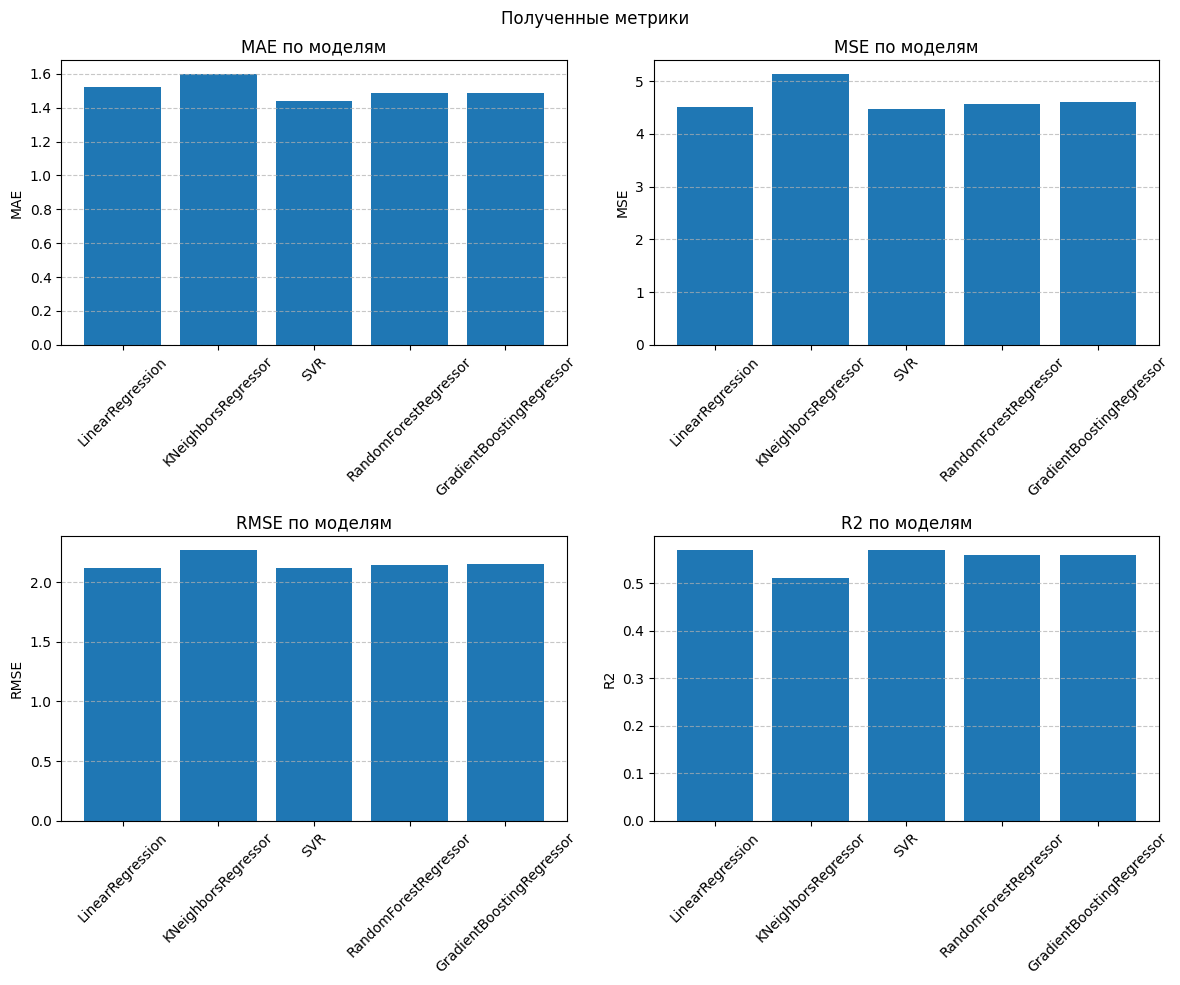

In [27]:
# Построение графиков по метрикам
df_melted = quality_comparison.melt(
    id_vars="Metrics", var_name="Model", value_name="Value"
)
metrics = quality_comparison["Metrics"].tolist()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    subset = df_melted[df_melted["Metrics"] == metric]
    axes[i].bar(subset["Model"], subset["Value"])
    axes[i].set_title(f"{metric.upper()} по моделям")
    axes[i].set_ylabel(metric.upper())
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Полученные метрики")
plt.tight_layout()
plt.show()

Можно видеть, что наибольшей точностью обладает модель SVR, она позволяет предсказывать возраст моллюсков с точностью до двух лет.

In [28]:
# Сохранение модели
joblib.dump(svr_model, "svr_model.joblib")

['svr_model.joblib']

# Задача 4. Применение инструментов AutoML

In [29]:
# Инициализация H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-11.0.26+4 (build 11.0.26+4, mixed mode)
  Starting server from C:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ivana\AppData\Local\Temp\tmpgbptka62
  JVM stdout: C:\Users\ivana\AppData\Local\Temp\tmpgbptka62\h2o_ivana_started_from_python.out
  JVM stderr: C:\Users\ivana\AppData\Local\Temp\tmpgbptka62\h2o_ivana_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Asia/Yekaterinburg
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 day
H2O_cluster_name:,H2O_from_python_ivana_iqo7yc
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.943 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [30]:
# Преобразование данных в формат H2O
features = [col for col in df.columns if col != TARGET]

df_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
df_train_scaled = pd.concat(
    [df_train_scaled, pd.DataFrame(y_train, columns=[TARGET])], axis=1
)

df_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

h2o_train_scaled = h2o.H2OFrame(df_train_scaled)
h2o_test_scaled = h2o.H2OFrame(df_test_scaled)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [31]:
# Запуск AutoML
aml = H2OAutoML(max_models=10, seed=1, sort_metric="RMSE")
aml.train(y=TARGET, x=features, training_frame=h2o_train_scaled)

AutoML progress: |
13:26:28.142: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
# GLM base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [32]:
# Просмотр результатов
lb = aml.leaderboard
lb.head(rows=5)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_BestOfFamily_1_AutoML_1_20250329_132628,2.11197,4.46041,1.50627,0.151046,4.46041
StackedEnsemble_AllModels_1_AutoML_1_20250329_132628,2.11596,4.47731,1.50343,0.151174,4.47731
GBM_1_AutoML_1_20250329_132628,2.15074,4.62567,1.53457,0.154233,4.62567
DeepLearning_1_AutoML_1_20250329_132628,2.1579,4.65652,1.53869,0.155737,4.65652
GBM_2_AutoML_1_20250329_132628,2.15904,4.66146,1.52372,0.154224,4.66146


Наибольшей точностью обладает ансамбль моделей, объединяющий предсказания лучших моделей каждого типа.

In [33]:
# Получение предсказаний модели AutoML и сравнение метрик
aml_model = aml.leader
y_pred_aml = aml_model.predict(h2o_test_scaled)

y_pred_aml = y_pred_aml.as_data_frame(use_multi_thread=True)
y_pred_aml = y_pred_aml.values.flatten()

quality_comparison["AutoML"] = [
    *map(
        lambda x: round(x, 2),
        get_metrics(y_test, y_pred_aml).values(),
    )
]

quality_comparison

stackedensemble prediction progress: |

███████████████████████████████████████████| (done) 100%


c:\Users\ivana\MLInnopolis\.mlinnopolis\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,Metrics,LinearRegression,KNeighborsRegressor,SVR,RandomForestRegressor,GradientBoostingRegressor,AutoML
0,mae,1.52,1.60,1.44,1.49,1.49,1.46
1,mse,4.51,5.14,4.48,4.56,4.61,4.41
2,rmse,2.12,2.27,2.12,2.14,2.15,2.10
3,r2,0.57,0.51,0.57,0.56,0.56,0.58


Можно видеть, что с помощью AutoML получен анламбль моделей, несклько превосходящий по точности результаты модели SVR.

In [34]:
# Сохранение модели AutoML
h2o.save_model(model=aml_model, path="./aml_models/", force=True)

'C:\\Users\\ivana\\MLInnopolis\\Module3\\Assessment3\\aml_models\\StackedEnsemble_BestOfFamily_1_AutoML_1_20250329_132628'

In [35]:
# Сохранение таблицы с метриками
quality_comparison.to_csv("quality_comparison.csv", index=False)